In [1]:
from time import monotonic
from sys import path
from os import getenv
path.append(getenv("HOME") + "/projects/travnik")
from travnik import glob
print("......")
start = monotonic()
torrents = glob("/var/opt/travnik")
print(len(torrents), "@", monotonic()-start, "s")
# t = Torrent()
# t.file("/root/projects/travnik/449a38ef7e042bd2d75e8921aa02f6f244165d9d.torrent")
# print(t.sha1.hex())
# for path, length in t.paths():
#     print(path, length)
# print(t)

......
fixed bad single file torrent 4f269d8aefd647ee270842d53ec98aebd23a4afe
fixed bad single file torrent 7b09ae0b612dafc1744562dccbbe4becf4d633c3
47843 @ 723.5033559300937 s


In [2]:
s = monotonic()
prej = None
skup = 0
dat = 0
vel = 0
for torrent in sorted([torrent for sha1, torrent in torrents.items()], key=lambda x:x.dict.get(b'creation date')):
    č = torrent.dict.get(b'creation date')
    dat += sum(1 for path, size in torrent.paths())
    vel += sum(size for path, size in torrent.paths())
    if not prej:
        prej = č
        continue
    if prej + 60*10 > č:
        skup += č-prej
    prej = č
print(monotonic()-s, "torrenti so se zbirali", skup/86400, "dni. en torrent je bil najden v povprečju na", skup/len(torrents), "sekund, v", len(torrents), "so metapodatki", dat, "datotek", "v skupni velikosti", vel/(1024**4), "TiB")

5.509342634119093 torrenti so se zbirali 16.265196759259258 dni. en torrent je bil najden v povprečju na 29.373429759839475 sekund, v 47843 so metapodatki 3084321 datotek v skupni velikosti 259.2602232018344 TiB


<IPython.core.display.Javascript object>


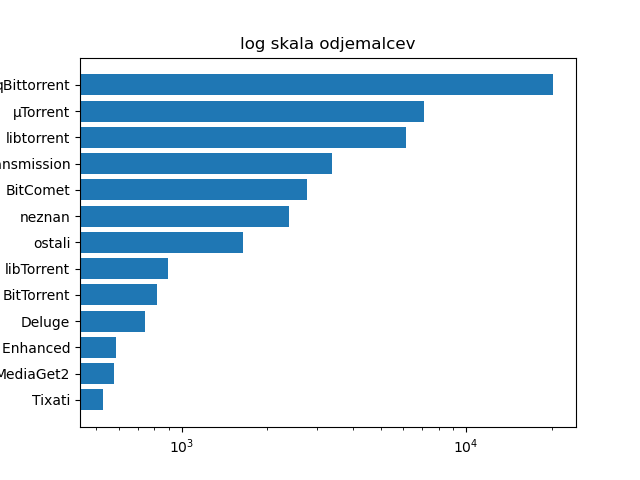

8.196780784986913 za 70 različnih odjemalcev


In [3]:
s = monotonic()
def uas(normalize=True, minrepr=0):
    odjemalci = {}
    for sha1, torrent in torrents.items():
        odjemalec = torrent.dict.get(b'source').get(b'v')
        if normalize and odjemalec is not None:
            if b'/' in odjemalec:
                odjemalec = odjemalec.split(b'/')[0]
            elif b' (' in odjemalec:
                odjemalec = odjemalec.split(b' (')[0]
            else:
                odjemalec = odjemalec.split(b' ')[0]
            odjemalec = odjemalec.replace(b'\xc2\xb5', b'\xce\xbc').decode()
        if odjemalec not in odjemalci.keys():
            odjemalci[odjemalec] = 1
        else:
            odjemalci[odjemalec] += 1
    trueodj = {"ostali": 0}
    count = 0
    for key, value in odjemalci.items():
        count += 1
        if value < minrepr:
            trueodj["ostali"] += value
        else:
            trueodj[key] = value
    trueodj = [(v, k) for k, v in trueodj.items()]
    return trueodj, count
odjemalci, count = uas(True, minrepr=0.01*len(torrents))
odjemalci = sorted(odjemalci, reverse=False)
from matplotlib import pyplot
%matplotlib notebook
fig, axes = pyplot.subplots()
from math import log
# axes.pie([log(sights) if sights else 0 for sights, name in odjemalci], labels=[name for sights, name in odjemalci])
axes.barh([name if name is not None else "neznan" for sights, name in odjemalci], [sights for sights, name in odjemalci])
axes.set_title("log skala odjemalcev")
pyplot.xscale("log")
fig.show()
print(monotonic()-s, "za", count, "različnih odjemalcev")

0.2505375409964472 s 41


<IPython.core.display.Javascript object>


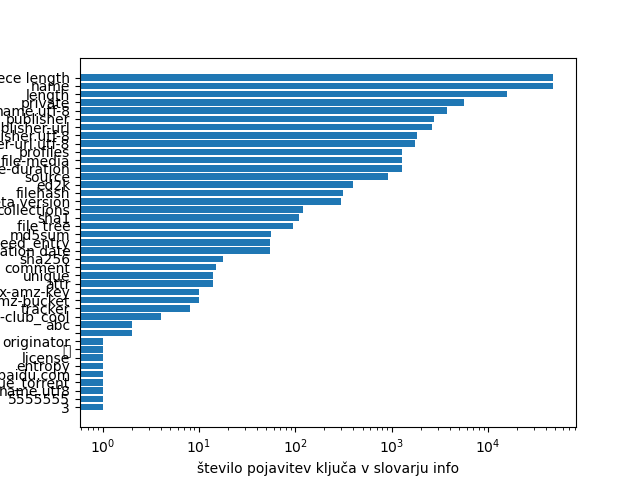

3 [1, '', '93f549c401bebe4f86ef23626e0fed3d06183b02']
5555555 [1, '555555555555555555', '93f549c401bebe4f86ef23626e0fed3d06183b02']
name.utf8 [1, 'Connections', 'a23296ce90328791cb6974cf6f6306da4dd89735']
unique_torrent [1, 1, '2c3ea79de0771079e41fc25f4cabf23e11041829']
www.baidu.com [1, 'www.baidu.com', '43b238596c66575e7dfcd4d5b1d0fadb6c393adc']
entropy [1, 1460043970, '0635e6c7d348c2603501e9fa53e4cf07f9e31b5e']
license [1, OrderedDict([(b'creative-commons', OrderedDict([(b'attributionAuthor', b'Dave Doobie Aaron'), (b'attributionTitle', b'Doobie'), (b'attributionUrl', b'http://fb.com/doobiebrooklyn'), (b'licenseUrl', b'http://creativecommons.org/licenses/by-nc/4.0/')]))]), '1d670c41fd340c8ee280157400744402740fc1fd']
还 [1, '百度', '647e1210953d6080f714f0f8dabffe6ee9852800']
originator [1, b'0\x82\x03:0\x82\x02"\x02\x01\x010\r\x06\t*\x86H\x86\xf7\r\x01\x01\x05\x05\x000L1\x0b0\t\x06\x03U\x04\x06\x13\x02US1\x0b0\t\x06\x03U\x04\x08\x13\x02CA1\x170\x15\x06\x03U\x04\n\x13\x0eBitTorrent Inc1\

In [4]:
s = monotonic()
keys = {}
for sha1, torrent in torrents.items():
    for key in torrent.dict.get(b'info').keys():
        if key.decode() not in keys.keys():
            value = torrent.dict.get(b'info').get(key)
            if type(value) is bytes:
                try:
                    value = value.decode()
                except UnicodeDecodeError:
                    pass
            keys[key.decode()] = [1, value, sha1.hex()]
        else:
            keys[key.decode()][0] += 1
sort = sorted(keys, key=lambda x: keys[x][0])
print(monotonic()-s, "s", len(keys))
%matplotlib notebook
fig, ax = pyplot.subplots();
ax.barh(sort, [keys[x][0] for x in sort])
pyplot.xscale("log")
pyplot.xlabel("število pojavitev ključa v slovarju info")
fig.show() ## TODO komentiraj
for i in sort:
    print(i, keys[i])

0.10204320191405714 s 92.3207156741843 brez ključa source, publisher, publisher-url ali comment 854 virov


<IPython.core.display.Javascript object>


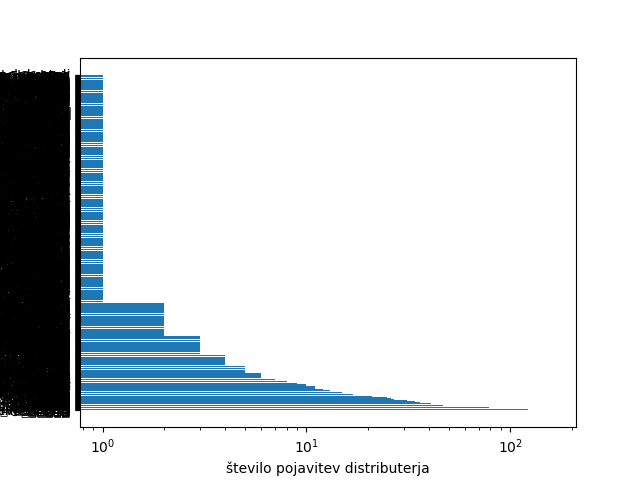

163 	 PMEDIA
130 	 http://tapochek.net/index.php
122 	 高清下载吧！
122 	 https://FreeCourseWeb.com
93 	 灣搭拉咩拉
88 	 脫拉庫
82 	 第一會所新片@SIS001
79 	 大师兄福利网
77 	 2048
75 	 1024社區最新地址
74 	 
64 	 LostFilm.TV
47 	 [https://tanhuazu.com] 探花族社区
46 	 2048核基地
44 	 https://hjd.tw
43 	 1024核工厂
42 	 RV原创
41 	 1024社區
39 	 小贾_KTXP
37 	 國產精品
36 	 麻豆之神
34 	 吃雞大神
34 	 b48t.com
33 	 https://crackshash.com/
33 	 老含及
31 	 欧宝
30 	 https://rh2048.com
27 	 小隻馬
27 	 1024
27 	 AV大平台
26 	 @蜂鳥论坛@
25 	 Weagogo
25 	 第一會所新片
25 	 JAV Torrent 掲示板
22 	 发发发
21 	 刷刷刷
21 	 https://1tors.ru/
20 	 1024工厂
20 	 hjd.tw
19 	 不予
17 	 小樱
17 	 (美女裸聊直播 uur68.com)
17 	 xue0117
15 	 美女裸聊直播
15 	 xp1024
15 	 老司机论坛
15 	 b'\xcf\xeb\xb7\xa2\xc8\xb4\xb2\xbb\xbb\xe1'
14 	 olo
13 	 nyaa001
13 	 b'dioguitar23(\xb2\xc4\xa4\xbb\xa4\xd1\xc5]\xa4\xfd)\xad\xec\xb3\xd0'
13 	 https://discord.gg/vbJ7RTn
13 	 PiRaX @ TamilBlasters.Net
13 	 愛在黑夜001
12 	 b'\xb3\xcc\xb7sAV \xa4\xd1\xaa\xc5\xbd\xd7\xbe\xc2 IP'
12 	 Zamunda.NET
11 	 [animelayer.ru] Animelayer
11 	 

In [5]:
s = monotonic()
def removeminorities(population, minrepr=0, ostalo="ostalo"):
    true = {ostalo: 0}
    for key, value in population.items():
        if value < minrepr:
            true[ostalo] += value
        else:
            true[key] = value
    return true
def sources():
    sources = {}
    for sha1, torrent in torrents.items():
        source = torrent.dict.get(b'info').get(b'source')
        if source is None:
            source = torrent.dict.get(b'info').get(b'publisher')
        if source is None:
            source = torrent.dict.get(b'info').get(b'publisher-url')
        if source is None:
            source = torrent.dict.get(b'info').get(b'comment')
        try:
            if type(source) is bytes:
                source = source.decode().strip()
        except UnicodeDecodeError:
            pass
        if source not in sources.keys():
            sources[source] = 1
        else:
            sources[source] += 1
    return sources
sources = sources()
sources = removeminorities(sources, len(sources)*0, "ostali")
sort = sorted(sources, reverse=True, key=lambda x:sources[x])
sort.remove(None)
print(monotonic()-s, "s", sources[None]/len(torrents)*100, "brez ključa source, publisher, publisher-url ali comment", len(sources), "virov")
%matplotlib notebook
fig, ax = pyplot.subplots();
ax.barh([str(x) for x in sort], [sources[x] for x in sort])
pyplot.xscale("log")
pyplot.xlabel("število pojavitev distributerja")
fig.show() ## TODO komentiraj
from tabulate import tabulate
tabulate([[x, sources[x]] for x in sort], tablefmt="html")
for x in sort:
    print(sources[x], "\t", x)

In [6]:
s = monotonic()
from mimetypes import guess_type
def ext(mime=False, minreprratio=0):
    bycount = {}
    bysize = {}
    bysizerepresentative = {}
    filescount = 0
    bytescount = 0
    for sha1, torrent in torrents.items():
        try:
            representatives = {}
            for path, size in torrent.paths():
                filescount += 1
                bytescount += size
                if mime:
                    ext = guess_type(path.pop().decode(encoding="iso-8859-2"))[0]
                else:
                    ext = path.pop().split(b'.').pop().decode(encoding="iso-8859-2").lower()
                if ext not in bycount.keys():
                    bycount[ext] = 1
                else:
                    bycount[ext] += 1
                if ext not in bysize.keys():
                    bysize[ext] = size
                else:
                    bysize[ext] += size
                if ext not in representatives.keys():
                    representatives[ext] = size
                else:
                    representatives[ext] += size
        except AttributeError:
            print(sha1.hex(), torrent)
            raise AttributeError
        try:
            representative = sorted(representatives, key=lambda x:representatives[x]).pop()
        except IndexError:
            print(sha1.hex(), torrent)
            raise IndexError
        if representative not in bysizerepresentative.keys():
            bysizerepresentative[representative] = 1
        else:
            bysizerepresentative[representative] += 1
    truebycount = removeminorities(bycount, minreprratio*filescount, "ostale")
    truebysize = removeminorities(bysize, minreprratio*bytescount, "ostale")
    truebysizerepresentative = removeminorities(bysizerepresentative, minreprratio*len(torrents), "ostale")
    for data in [truebycount, truebysize, truebysizerepresentative]:
        data = [(v, k) for k, v in data.items()]
    return truebycount, truebysize, truebysizerepresentative, len(bycount), filescount, bytescount
print("...")
bycount, bysize, bysizerepresentative, kinds, filescount, bytescount = ext(False, 0.001)
print(monotonic()-s, "s", kinds, "različnih tipov v", filescount, "datotekah in", bytescount/(1024**4), "TiB")

...
9.945079553872347 s 335643 različnih tipov v 3084321 datotekah in 259.2602232018344 TiB


<IPython.core.display.Javascript object>


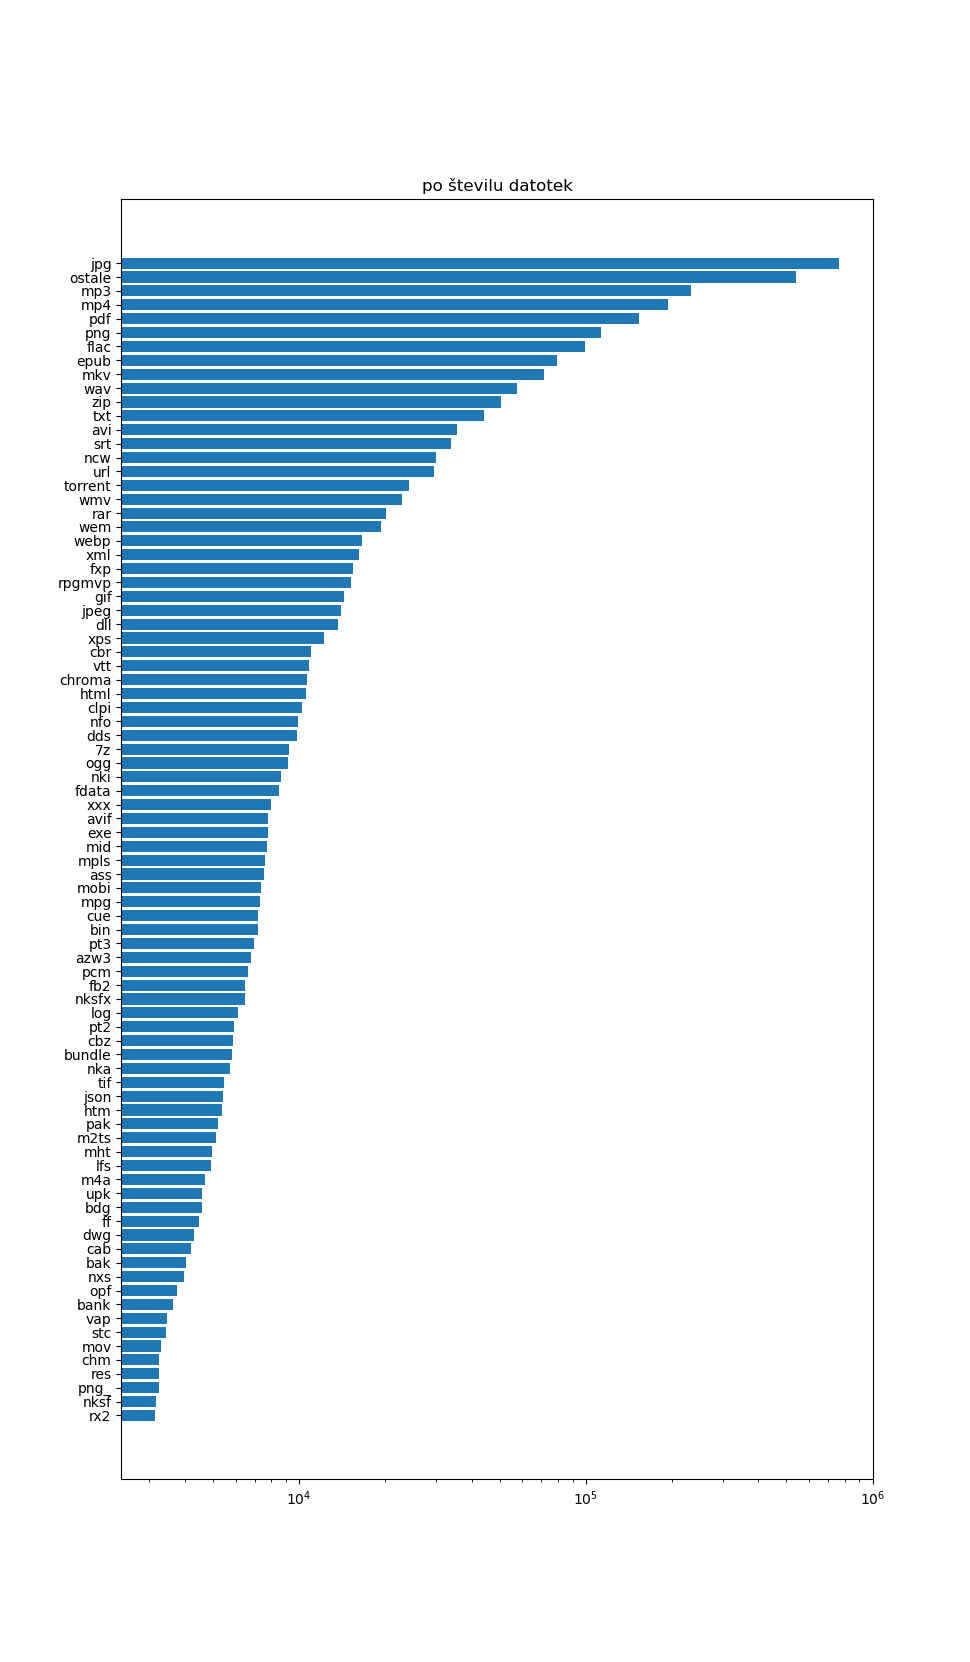

<IPython.core.display.Javascript object>


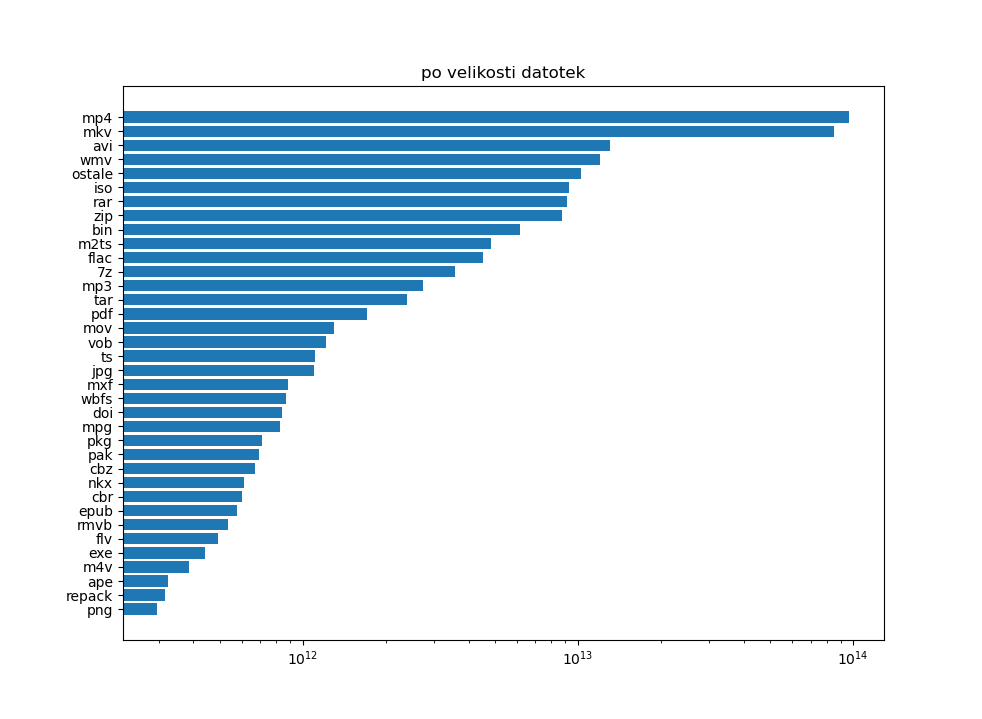

<IPython.core.display.Javascript object>


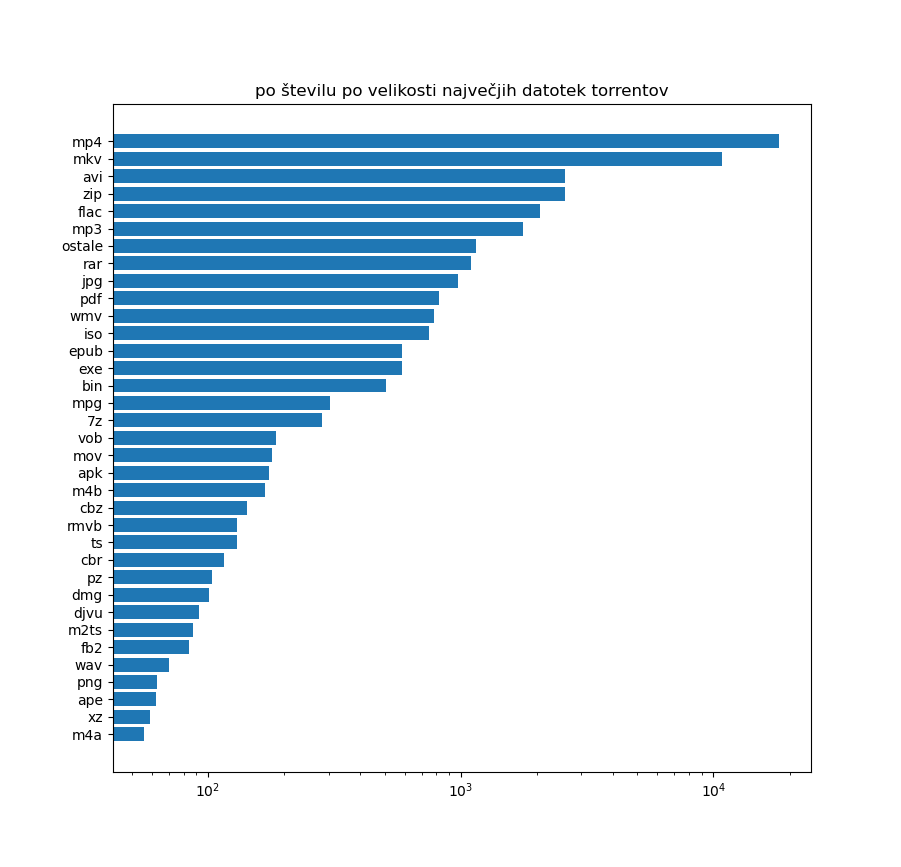

In [7]:
sortcount = sorted(bycount, reverse=False, key=lambda x: bycount[x])
sortsize = sorted(bysize, reverse=False, key=lambda x: bysize[x])
sortsizerepresentative = sorted(bysizerepresentative, reverse=False, key=lambda x: bysizerepresentative[x])
from matplotlib import pyplot
%matplotlib notebook
for desc, data in {"po številu datotek": (sortcount, bycount), "po velikosti datotek": (sortsize, bysize), "po številu po velikosti največjih datotek torrentov": (sortsizerepresentative, bysizerepresentative)}.items():
    fig, axes = pyplot.subplots()
    # axes.pie([data[1][key] for key in data[0]], labels=data[0])
    axes.barh(data[0], [data[1][key] for key in data[0]])
    pyplot.xscale("log")
    axes.set_title(desc)
    fig.show()